In [1]:
import os as os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN
import calendar
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn import preprocessing
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

Using TensorFlow backend.


In [2]:
#seting working directory
os.chdir("C:/Users/hp/Desktop/Project cap fare prediction")

In [3]:
#importing training and test data
train=pd.read_csv("train_cab.csv",dtype={"fare_amount":np.float},na_values={"fare_amount":"430-"})
test=pd.read_csv("test.csv")

In [4]:
train.describe() 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [5]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [6]:
#Checking data types
train.info() , test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(6), object(1)
memory usage: 878.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


(None, None)

In [7]:
#lets make a copy of both the data fare
test_copy=test.copy()
train_copy=train.copy()

We can clearly see that fare_amount and passenger_counts in train data have missing values

# Data Exploration and Data cleaning

In [4]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


1) Understanding passenger_count

In [9]:
train["passenger_count"].describe() , test["passenger_count"].describe()

(count    16012.000000
 mean         2.625070
 std         60.844122
 min          0.000000
 25%          1.000000
 50%          1.000000
 75%          2.000000
 max       5345.000000
 Name: passenger_count, dtype: float64, count    9914.000000
 mean        1.671273
 std         1.278747
 min         1.000000
 25%         1.000000
 50%         1.000000
 75%         2.000000
 max         6.000000
 Name: passenger_count, dtype: float64)

passenger_count maximum and minimum values in test data is 6 and 1. but over train data have maximum value of 5345 which is not making sense. Lets plot the distribution curve for passenger count to understand it batter.

C:\Users\hp\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\hp\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


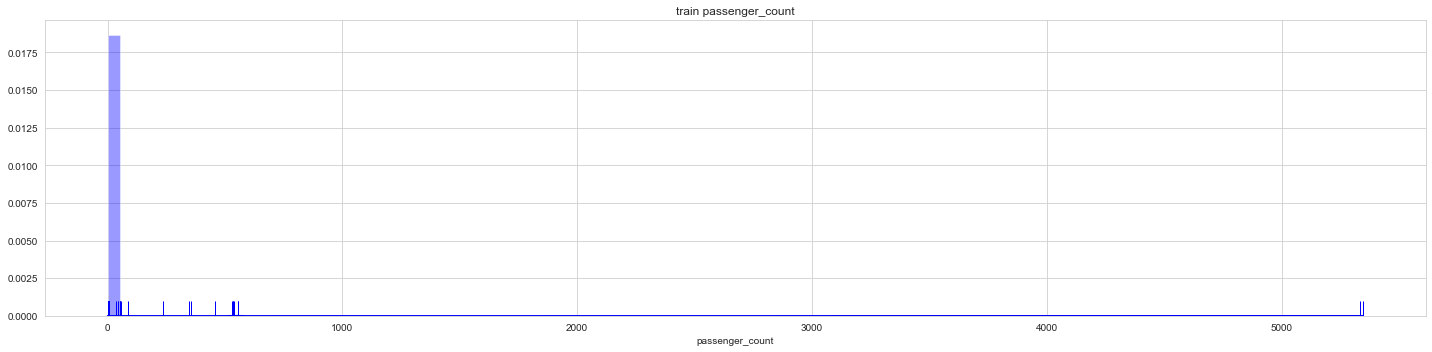

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
sns.distplot(train["passenger_count"],bins=100,color="blue",rug=True).set_title("train passenger_count")
plt.tight_layout()

Lets check how many values lies outside the range of (1,6)

In [8]:
train[(train["passenger_count"]<1) | (train["passenger_count"]>6)].count()

fare_amount          77
pickup_datetime      78
pickup_longitude     78
pickup_latitude      78
dropoff_longitude    78
dropoff_latitude     78
passenger_count      78
dtype: int64

In [4]:
#Droping the observations
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [13]:
#Replacing with NA in copied file
#train.loc[((train["passenger_count"]<1) | (train["passenger_count"]>6)),"passenger_count"] = np.nan

C:\Users\hp\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\hp\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


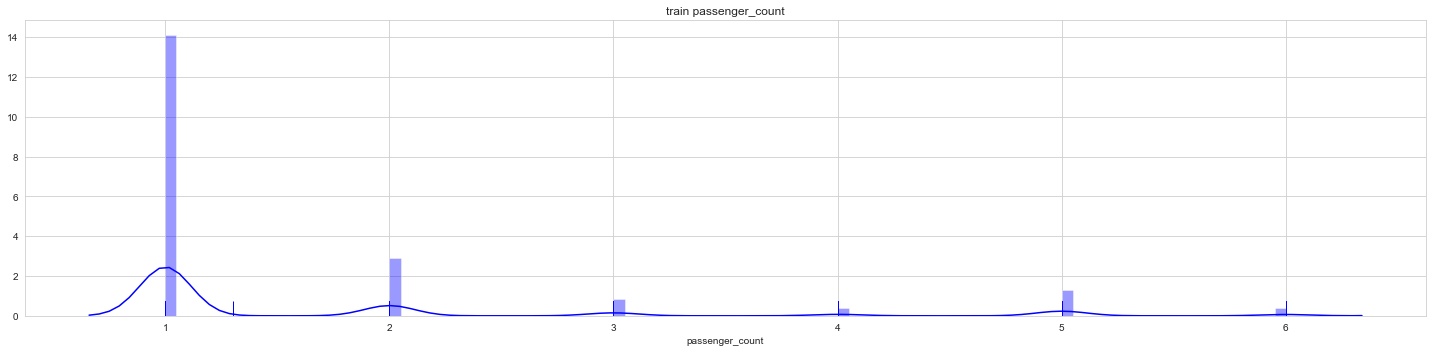

In [5]:
#Lets again plot the dist for passenger count 
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
sns.distplot(train["passenger_count"],bins=100,color="blue",rug=True).set_title("train passenger_count")
plt.tight_layout()

Most of the values for passenger_count is 1. As we can see above one value of passenger_couunt is not integer it liers between 1 and 2 , which is also not making any sense. so lets round the values of passenger_count to nearest integer which is 1

In [10]:
train["passenger_count"]=train["passenger_count"].round()

In [11]:
train["passenger_count"].nunique(),train["passenger_count"].describe()

(6, count    15934.000000
 mean         1.649617
 std          1.265903
 min          1.000000
 25%          1.000000
 50%          1.000000
 75%          2.000000
 max          6.000000
 Name: passenger_count, dtype: float64)

In [12]:
#passenger_count is the category type data type, lets convet it to its datatype
train["passenger_count"]=train["passenger_count"].astype(object)
test["passenger_count"]=test["passenger_count"].astype(object)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15989 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          15965 non-null float64
pickup_datetime      15989 non-null object
pickup_longitude     15989 non-null float64
pickup_latitude      15989 non-null float64
dropoff_longitude    15989 non-null float64
dropoff_latitude     15989 non-null float64
passenger_count      15934 non-null object
dtypes: float64(5), object(2)
memory usage: 999.3+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null object
dtypes: float64(4), object(2)
memory usage: 464.8+ KB


2) fare_amount

In [20]:
train["fare_amount"].describe()

count    15965.000000
mean        15.044053
std        431.497457
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

As we can see some of the values of faer_amount is negative(as minimum value is -3) which is not making any sense. also the fare_Amount less than 1 and values which are extremly high is also have to be treat. so lets first plot the distribution of fare_amount.

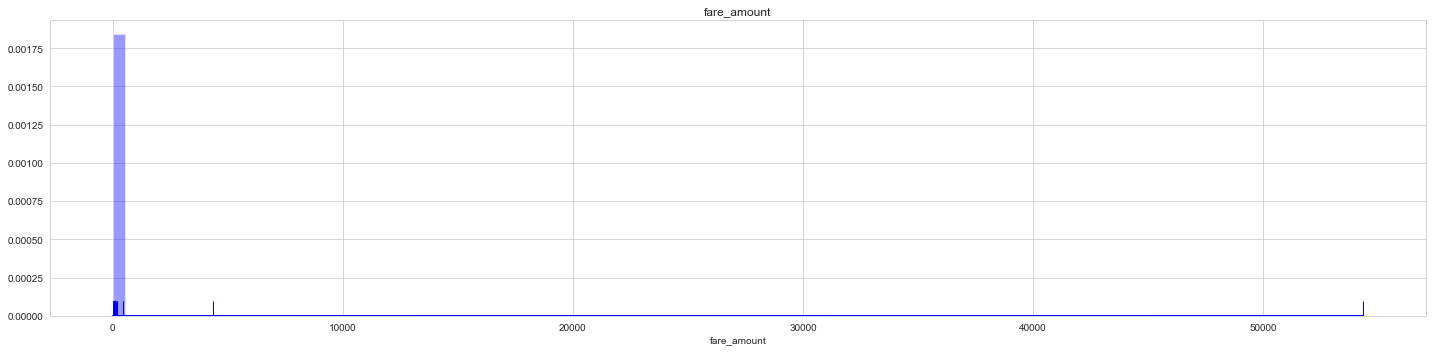

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
sns.distplot(train["fare_amount"],bins=100,color="blue",rug=True).set_title("fare_amount")
plt.tight_layout()

So almost all the values are not near to maximum value of fare_amount implies this maximum value is nosiy data. lets plot distribution curver for fare_amount (0,500) for better under standiing

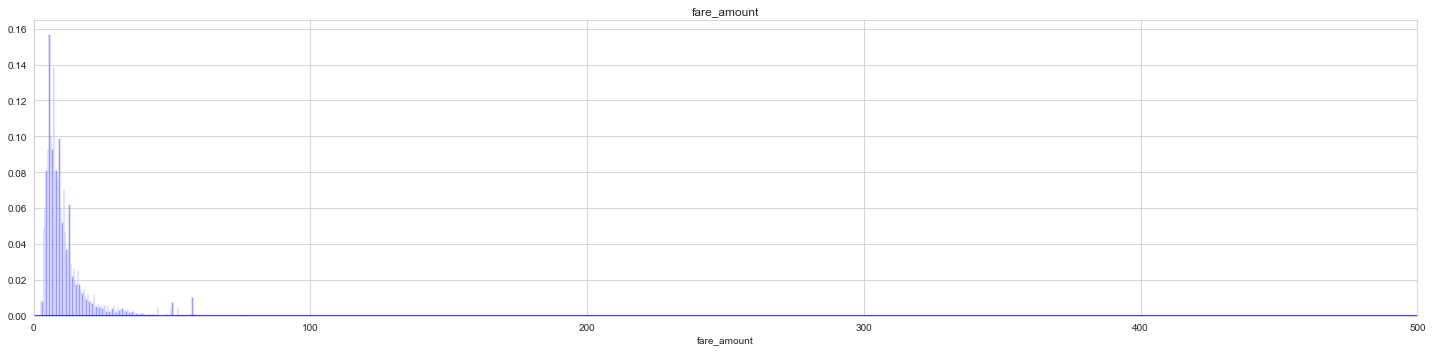

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
sns.distplot(train["fare_amount"],bins="auto",color="blue").set_title("fare_amount")
plt.xlim(0,500)
plt.tight_layout()

Now, for the unsensible values of fare_amount(smaller than 1 and greater than 200) what we can do is we are going to remove this values or we can replce them with NA then impute them using missing value imputation 

In [13]:
#Removing these observations
train = train.drop(train[train["fare_amount"]<1].index, axis=0)
train = train.drop(train[train["fare_amount"]>200].index, axis=0)

In [10]:
#Repalce the with NA
# train.loc[train["fare_amount"] < 1,"fare_amount"] = np.nan
# train.loc[train["fare_amount"] > 200,"fare_amount"] = np.nan

In [14]:
train["fare_amount"].describe()

count    15956.000000
mean        11.319484
std          9.663580
min          1.140000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15980 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          15956 non-null float64
pickup_datetime      15980 non-null object
pickup_longitude     15980 non-null float64
pickup_latitude      15980 non-null float64
dropoff_longitude    15980 non-null float64
dropoff_latitude     15980 non-null float64
passenger_count      15925 non-null object
dtypes: float64(5), object(2)
memory usage: 998.8+ KB


3) latitude and longitude data

As from latitude and longitude understanding, latitude is always between -90 to 90 and longitude is always between -180 to 180.
lets check for the values which is outside these in our data.

In [15]:
train["dropoff_latitude"].describe(),train["dropoff_longitude"].describe(),train["pickup_latitude"].describe(),train["pickup_longitude"].describe()

(count    15980.000000
 mean        39.898386
 std          6.187519
 min        -74.006377
 25%         40.734716
 50%         40.753585
 75%         40.768029
 max         41.366138
 Name: dropoff_latitude, dtype: float64, count    15980.000000
 mean       -72.463365
 std         10.572202
 min        -74.429332
 25%        -73.991181
 50%        -73.980166
 75%        -73.963643
 max         40.802437
 Name: dropoff_longitude, dtype: float64, count    15980.000000
 mean        39.920403
 std          6.815687
 min        -74.006893
 25%         40.734947
 50%         40.752640
 75%         40.767413
 max        401.083332
 Name: pickup_latitude, dtype: float64, count    15980.000000
 mean       -72.473075
 std         10.544433
 min        -74.438233
 25%        -73.992155
 50%        -73.981695
 75%        -73.966830
 max         40.766125
 Name: pickup_longitude, dtype: float64)

`from above as we can see that the values are lies under the sensible range for all except pickup_latitude as its maximum value is 401 which is not making any sence. so lets find out how many values are greater than 90.

In [16]:
train[train['pickup_latitude']>90].count()

fare_amount          1
pickup_datetime      1
pickup_longitude     1
pickup_latitude      1
dropoff_longitude    1
dropoff_latitude     1
passenger_count      1
dtype: int64

we can drop this value or we can replace it with na than impute it using methods of missing value impuataion

In [17]:
#Removing the Observation
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)

In [51]:
# Replacing it with NA
# train.loc[train["pickup_latitude"]>90,"pickup_latitude"]=np.nan

Lets plot distribution curve for latitude and longitude to understand the data

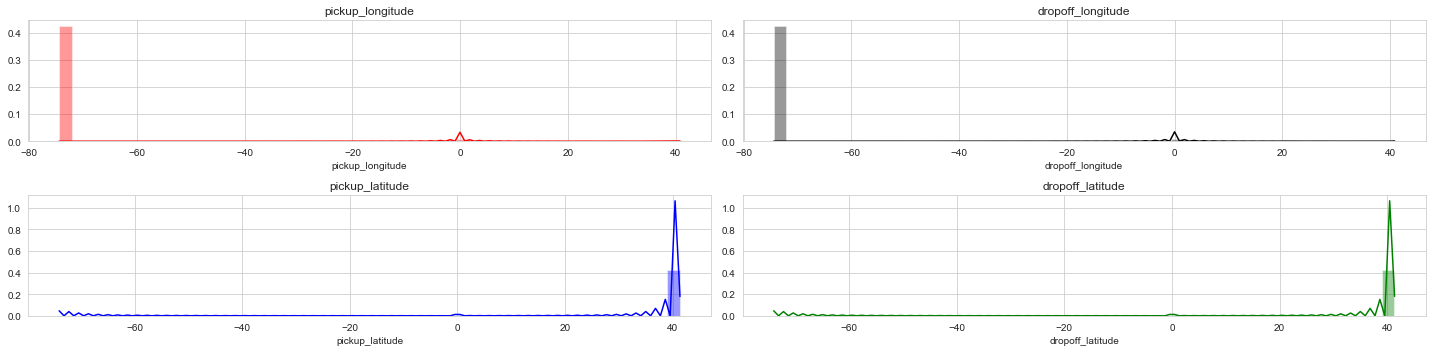

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.subplot(221)
sns.distplot(train["pickup_longitude"],color="red").set_title("pickup_longitude")
plt.subplot(222)
sns.distplot(train["dropoff_longitude"],color="black").set_title("dropoff_longitude")
plt.subplot(223)
sns.distplot(train["pickup_latitude"],color="blue").set_title("pickup_latitude")
plt.subplot(224)
sns.distplot(train["dropoff_latitude"],color="green").set_title("dropoff_latitude")
plt.tight_layout()

Most of the values for latitude lies near to 40 and longitude lies near to -73, From internet site Latlong.net we found out these points are for Newyork city. All the other values fare from these values are may be outliers or noisy data.Lets plot some visulaization for test latitude and longitude to find out.

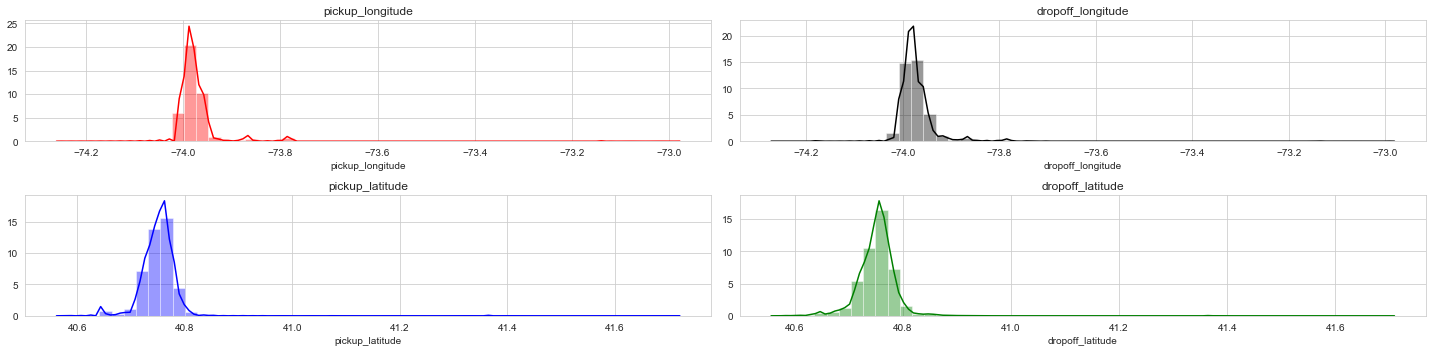

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.subplot(221)
sns.distplot(test["pickup_longitude"],color="red").set_title("pickup_longitude")
plt.subplot(222)
sns.distplot(test["dropoff_longitude"],color="black").set_title("dropoff_longitude")
plt.subplot(223)
sns.distplot(test["pickup_latitude"],color="blue").set_title("pickup_latitude")
plt.subplot(224)
sns.distplot(test["dropoff_latitude"],color="green").set_title("dropoff_latitude")
plt.tight_layout()

From above we can see that latitude range from (39,42) roughgly and longitude ranges from (-75,-72) rounghly.  

In [18]:
a=train[(train["pickup_longitude"] < -75) | (train["pickup_longitude"]>-72) | (train["dropoff_longitude"] < -75) | 
     (train["dropoff_longitude"]>-72) | (train["pickup_latitude"] < 39) | (train["pickup_latitude"]> 42) 
         | (train["dropoff_latitude"] < 39) | (train["dropoff_latitude"]> 42)]

In [19]:
a

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3
15,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1
26,NaN,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1
124,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2
192,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...
15920,8.1,2012-05-18 04:44:00 UTC,0.0,0.0,0.0,0.0,1
15929,10.9,2010-05-18 20:34:00 UTC,0.0,0.0,0.0,0.0,5
15937,3.3,2009-10-01 20:32:00 UTC,0.0,0.0,0.0,0.0,3
16014,10.9,2011-03-04 14:05:00 UTC,0.0,0.0,0.0,0.0,2


There are total 333 such observation but most of these values of latitude and longitude is 0. lets find out how many observation with 0 latitude and longitude

Now what we can do is we can remove these observations or we can replace them with na than impute them as missing value

In [20]:
train.shape

(15979, 7)

In [21]:
#Removing the observations
train = train.drop(train[train['pickup_latitude']>42].index, axis=0)
train = train.drop(train[train['pickup_latitude']<39].index, axis=0)
train = train.drop(train[train['dropoff_latitude']>42].index, axis=0)
train = train.drop(train[train['dropoff_latitude']<39].index, axis=0)
train = train.drop(train[train['pickup_longitude']>-72].index, axis=0)
train = train.drop(train[train['pickup_longitude']<-75].index, axis=0)
train = train.drop(train[train['dropoff_longitude']>-72].index, axis=0)
train = train.drop(train[train['dropoff_longitude']<-75].index, axis=0)

In [22]:
train.shape

(15646, 7)

In [64]:
#Replacing with NA
#train.loc[train["pickup_latitude"]>42,"pickup_latitude"]=np.nan
#train.loc[train["pickup_latitudek"]<39,"pickup_latitude"]=np.nan
#train.loc[train["dropoff_latitude"]>42,"dropoff_latitude"]=np.nan
#train.loc[train["dropoff_latitude"]<39,"dropoff_latitude"]=np.nan
#train.loc[train["pickup_longitude"]>-72,"pickup_longitude"]=np.nan
#train.loc[train["pickup_longitude"]<-75,"pickup_longitude"]=np.nan
#train.loc[train["dropoff_longitude"]>-72,"dropoff_longitude"]=np.nan
#train.loc[train["dropoff_longitude"]<-75,"dropoff_longitude"]=np.nan

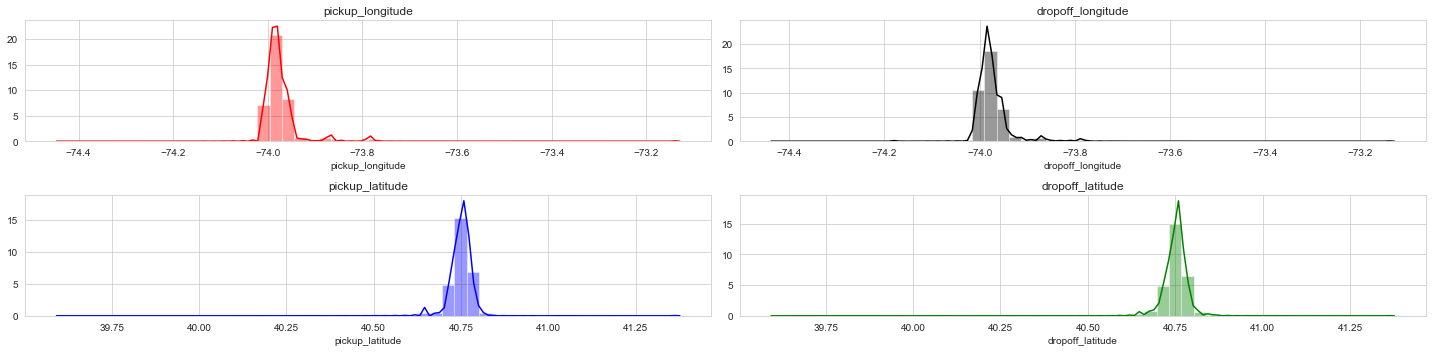

In [35]:
#Visulaization for latitude and longitude after cleaning
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.subplot(221)
sns.distplot(train["pickup_longitude"],color="red").set_title("pickup_longitude")
plt.subplot(222)
sns.distplot(train["dropoff_longitude"],color="black").set_title("dropoff_longitude")
plt.subplot(223)
sns.distplot(train["pickup_latitude"],color="blue").set_title("pickup_latitude")
plt.subplot(224)
sns.distplot(train["dropoff_latitude"],color="green").set_title("dropoff_latitude")
plt.tight_layout()

Text(336.9714285714286, 0.5, 'longitude')

<Figure size 720x720 with 0 Axes>

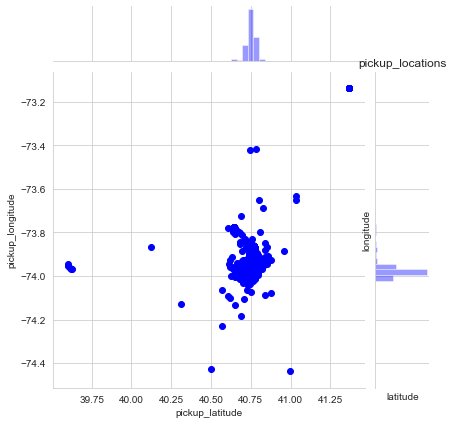

In [36]:
#Pickup_location
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.jointplot(kind="scatter", x="pickup_latitude", y="pickup_longitude",data=train,color='blue')
plt.title("pickup_locations")
plt.xlabel("latitude")
plt.ylabel("longitude")

Text(336.9714285714286, 0.5, 'longitude')

<Figure size 720x720 with 0 Axes>

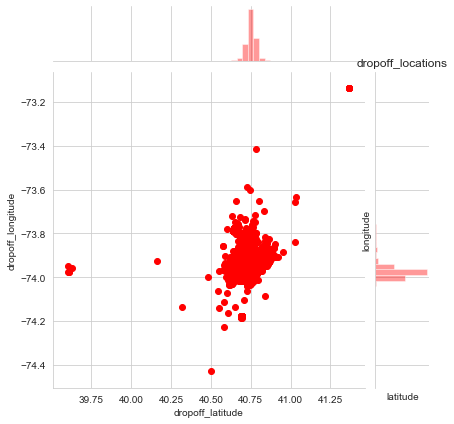

In [37]:
#dropoff_locations
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.jointplot(kind="scatter", x="dropoff_latitude", y="dropoff_longitude",data=train,color='red')
plt.title("dropoff_locations")
plt.xlabel("latitude")
plt.ylabel("longitude")

4) pickup_Datetime

In [23]:
train["pickup_datetime"].loc[1]

'2010-01-05 16:52:16 UTC'

In [23]:
#Lets change ite to datetime data type
train["pickup_datetime"]=pd.to_datetime(train["pickup_datetime"], format= "%Y-%m-%d %H:%M:%S UTC", errors="coerce")
test["pickup_datetime"]=pd.to_datetime(test["pickup_datetime"], format= "%Y-%m-%d %H:%M:%S UTC")

In [25]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15624.000000,15646.000000,15646.000000,15646.000000,15646.000000
mean,11.308458,-73.974832,40.750930,-73.973855,40.751418
std,9.610691,0.041510,0.037990,0.039343,0.039650
min,1.140000,-74.438233,39.603178,-74.429332,39.604972
25%,6.000000,-73.992392,40.736587,-73.991372,40.736321
50%,8.500000,-73.982053,40.753357,-73.980567,40.754256
75%,12.500000,-73.968104,40.767811,-73.965396,40.768332
max,180.000000,-73.137393,41.366138,-73.137393,41.366138


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15646 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          15624 non-null float64
pickup_datetime      15645 non-null datetime64[ns]
pickup_longitude     15646 non-null float64
pickup_latitude      15646 non-null float64
dropoff_longitude    15646 non-null float64
dropoff_latitude     15646 non-null float64
passenger_count      15591 non-null object
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.6+ MB


We have done with our data cleaning process lets check for missing values now

# Missing values

In [24]:
#Checking for missing value
missing_value= pd.DataFrame(train.isnull().sum())
missing_value = missing_value.reset_index()
missing_value

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [25]:
#Converting it in Missing %
missing_value = missing_value.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_value['Missing_percentage'] = (missing_value['Missing_percentage']/len(train))*100
missing_value = missing_value.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_value

,Variables,Missing_percentage
0,passenger_count,0.351528
1,fare_amount,0.140611
2,pickup_datetime,0.006391
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


we can drop these missing values or we can impute them using missing value imputation methods

In [26]:
#dropping missing values
train = train.drop(train[train["passenger_count"].isnull()].index,axis = 0)
train = train.drop(train[train["fare_amount"].isnull()].index,axis = 0)
train = train.drop(train[train["pickup_datetime"].isnull()].index,axis = 0)

In [27]:
train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [28]:
train.shape

(15568, 7)


#imputing missing values

we can use different methods for missing value imputations- central tendency method and KNN Imputation method
#So before using KNN Imputation for missing lets drop the pickup_datetime variable,we merge it again.

In [39]:
#pickup_datetime=pd.DataFrame(train["pickup_datetime"])

In [40]:
#pickup_datetime=pickup_datetime.reset_index(drop=True)

1) passenger_count

In [85]:
#   We first create a missing value than impute it using different methods we select the method for which the impute 
#   value is closest to actual value.
#   Passenger count have only integer values so it is a categorical type data, we can impute missing values by mode 
#   or by KNN imputation method.
#   Actual value: 1.0
#   Value when we use mode: 1.0 
#   value on using KNN: 1.0

In [41]:
#Lets first check the value at some random position
#train["passenger_count"].loc[1000]

1.0

In [43]:
#imputation using mode
#df=train.copy()
#df["passenger_count"].loc[1000]=np.nan
#df['passenger_count'].fillna(df['passenger_count'].mode()[0]).loc[1000]

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1.0

In [44]:
#Now impute passenger_count using KNN Imputation method
#df=train.copy()
#df["passenger_count"].loc[1000]=np.nan
#columns=["fare_amount","pickup_longitude","pickup_latitude","dropoff_longitude", "dropoff_latitude", "passenger_count"]
#df=pd.DataFrame(KNN(k = 5).fit_transform(df.drop('pickup_datetime',axis=1)),columns=columns)
#df.loc[1000]

Imputing row 1/16067 with 0 missing, elapsed time: 135.881
Imputing row 101/16067 with 0 missing, elapsed time: 139.714
Imputing row 201/16067 with 0 missing, elapsed time: 139.801
Imputing row 301/16067 with 0 missing, elapsed time: 139.906
Imputing row 401/16067 with 0 missing, elapsed time: 139.913
Imputing row 501/16067 with 1 missing, elapsed time: 139.989
Imputing row 601/16067 with 0 missing, elapsed time: 140.007
Imputing row 701/16067 with 0 missing, elapsed time: 140.023
Imputing row 801/16067 with 0 missing, elapsed time: 140.030
Imputing row 901/16067 with 0 missing, elapsed time: 140.038
Imputing row 1001/16067 with 0 missing, elapsed time: 140.109
Imputing row 1101/16067 with 0 missing, elapsed time: 140.187
Imputing row 1201/16067 with 1 missing, elapsed time: 140.246
Imputing row 1301/16067 with 0 missing, elapsed time: 140.259
Imputing row 1401/16067 with 1 missing, elapsed time: 140.264
Imputing row 1501/16067 with 0 missing, elapsed time: 140.268
Imputing row 1601/16

Imputing row 16001/16067 with 0 missing, elapsed time: 141.368


fare_amount           6.000000
pickup_longitude    -74.000405
pickup_latitude      40.718570
dropoff_longitude   -74.000040
dropoff_latitude     40.726592
passenger_count       1.200000
Name: 500, dtype: float64

2) fare_amount

In [35]:
#We first create a missing value than impute it using mean, median and KNN method to find out the best fit method.
  #Actual value = 7.0
  #Value when we impute using mean = 11.31
  #Value when we impute using median = 8.5
  #Value when we impute using KNN = 7.46

In [50]:
#train["fare_amount"].loc[1000]

7.0

In [51]:
#imputation using mean
#df=train.copy()
#df["fare_amount"].loc[1000]=np.nan
#df['fare_amount'].fillna(df['fare_amount'].mean()).loc[1000]

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


11.30857597305387

In [52]:
#imputation using median
#df=train.copy()
#df["fare_amount"].loc[1000]=np.nan
#df['fare_amount'].fillna(df['fare_amount'].median()).loc[1000]

8.5

In [49]:
#imputation using KNN
#df=train.copy()
#df["fare_amount"].loc[1000]=np.nan
#columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
#pickup_datetime=pd.DataFrame(df["pickup_datetime"])
#pd.DataFrame(KNN(k = 5).fit_transform(df.drop('pickup_datetime',axis=1)),columns=columns).loc[1000]

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Imputing row 1/16067 with 0 missing, elapsed time: 70.041
Imputing row 101/16067 with 0 missing, elapsed time: 70.182
Imputing row 201/16067 with 0 missing, elapsed time: 70.345
Imputing row 301/16067 with 0 missing, elapsed time: 70.531
Imputing row 401/16067 with 0 missing, elapsed time: 70.533
Imputing row 501/16067 with 0 missing, elapsed time: 70.536
Imputing row 601/16067 with 0 missing, elapsed time: 70.660
Imputing row 701/16067 with 0 missing, elapsed time: 70.662
Imputing row 801/16067 with 0 missing, elapsed time: 70.665
Imputing row 901/16067 with 0 missing, elapsed time: 70.667
Imputing row 1001/16067 with 1 missing, elapsed time: 70.670
Imputing row 1101/16067 with 0 missing, elapsed time: 70.671
Imputing row 1201/16067 with 1 missing, elapsed time: 70.672
Imputing row 1301/16067 with 0 missing, elapsed time: 70.673
Imputing row 1401/16067 with 1 missing, elapsed time: 70.676
Imputing row 1501/16067 with 0 missing, elapsed time: 70.677
Imputing row 1601/16067 with 0 missi

fare_amount           7.460000
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       1.000000
Name: 1000, dtype: float64

3) latitude and longitude 

In [65]:
#We first create a missing value than impute it using mean, median and KNN method to find out the best fit method.
#              pickup_longitude      pickup_latitude      dropoff_longitude       dropoff_latitude                 
#Actual value     -73.9954              40.7597               -73.9876              40.7512
#mean             -73.9748              40.7509               -73.9738              40.7514
#median           -73.9820              40.7533               -73.9806              40.7542
#KNN              -73.9945              40.7465               -73.9882              40.7451

In [55]:
#train.loc[1000]

fare_amount                            7
pickup_datetime      2014-06-15 17:11:00
pickup_longitude                -73.9954
pickup_latitude                  40.7597
dropoff_longitude               -73.9876
dropoff_latitude                 40.7512
passenger_count                        1
Name: 1000, dtype: object

In [56]:
#imputation using mean
#df=train.copy()
#for i in["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]:
#    df[i].loc[1000]=np.nan
#    df[i]=df[i].fillna(df[i].mean())
    
#df.loc[1000]

fare_amount                            7
pickup_datetime      2014-06-15 17:11:00
pickup_longitude                -73.9748
pickup_latitude                  40.7509
dropoff_longitude               -73.9738
dropoff_latitude                 40.7514
passenger_count                        1
Name: 1000, dtype: object

In [57]:
#imputation using median
#df=train.copy()
#for i in["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]:
#    df[i].loc[1000]=np.nan
#    df[i]=df[i].fillna(df[i].median())
    
#df.loc[1000]

fare_amount                            7
pickup_datetime      2014-06-15 17:11:00
pickup_longitude                 -73.982
pickup_latitude                  40.7533
dropoff_longitude               -73.9806
dropoff_latitude                 40.7542
passenger_count                        1
Name: 1000, dtype: object

In [62]:
#imputation using KNN
#df=train.copy()

In [63]:
#for i in["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]:
#    df[i].loc[1000]=np.nan
    
#df.loc[1000]

fare_amount                            7
pickup_datetime      2014-06-15 17:11:00
pickup_longitude                     NaN
pickup_latitude                      NaN
dropoff_longitude                    NaN
dropoff_latitude                     NaN
passenger_count                        1
Name: 1000, dtype: object

In [64]:
#columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
#pickup_datetime=pd.DataFrame(df["pickup_datetime"])
#df=pd.DataFrame(KNN(k = 5).fit_transform(df.drop('pickup_datetime',axis=1)),columns=columns)
#df.loc[1000]

Imputing row 1/16067 with 0 missing, elapsed time: 71.396
Imputing row 101/16067 with 0 missing, elapsed time: 71.549
Imputing row 201/16067 with 0 missing, elapsed time: 71.560
Imputing row 301/16067 with 0 missing, elapsed time: 71.579
Imputing row 401/16067 with 0 missing, elapsed time: 71.590
Imputing row 501/16067 with 0 missing, elapsed time: 71.607
Imputing row 601/16067 with 0 missing, elapsed time: 71.614
Imputing row 701/16067 with 0 missing, elapsed time: 72.219
Imputing row 801/16067 with 0 missing, elapsed time: 72.227
Imputing row 901/16067 with 0 missing, elapsed time: 72.238
Imputing row 1001/16067 with 4 missing, elapsed time: 72.246
Imputing row 1101/16067 with 0 missing, elapsed time: 72.250
Imputing row 1201/16067 with 1 missing, elapsed time: 72.253
Imputing row 1301/16067 with 0 missing, elapsed time: 72.255
Imputing row 1401/16067 with 1 missing, elapsed time: 72.261
Imputing row 1501/16067 with 0 missing, elapsed time: 72.263
Imputing row 1601/16067 with 0 missi

fare_amount           7.000000
pickup_longitude    -73.994539
pickup_latitude      40.746501
dropoff_longitude   -73.988266
dropoff_latitude     40.745178
passenger_count       1.000000
Name: 1000, dtype: float64

In [67]:
#train.isna().sum()

fare_amount           34
pickup_datetime        1
pickup_longitude     324
pickup_latitude      325
dropoff_longitude    324
dropoff_latitude     322
passenger_count      133
dtype: int64

In [68]:
#we use Mean and median for imputing dropoff_latitude and pickup_latitude, and KNN for all other variable
#train["dropoff_latitude"]=train["dropoff_latitude"].fillna(train["dropoff_latitude"].median())
#train["pickup_latitude"]=train["pickup_latitude"].fillna(train["pickup_latitude"].mean())

In [69]:
#train.isna().sum()

fare_amount           34
pickup_datetime        1
pickup_longitude     324
pickup_latitude        0
dropoff_longitude    324
dropoff_latitude       0
passenger_count      133
dtype: int64

In [70]:
#columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
#train=pd.DataFrame(KNN(k = 5).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns)

Imputing row 1/16067 with 0 missing, elapsed time: 71.428
Imputing row 101/16067 with 0 missing, elapsed time: 73.352
Imputing row 201/16067 with 0 missing, elapsed time: 73.361
Imputing row 301/16067 with 0 missing, elapsed time: 73.366
Imputing row 401/16067 with 0 missing, elapsed time: 73.370
Imputing row 501/16067 with 0 missing, elapsed time: 73.373
Imputing row 601/16067 with 0 missing, elapsed time: 73.377
Imputing row 701/16067 with 0 missing, elapsed time: 73.379
Imputing row 801/16067 with 0 missing, elapsed time: 73.383
Imputing row 901/16067 with 0 missing, elapsed time: 73.386
Imputing row 1001/16067 with 0 missing, elapsed time: 73.389
Imputing row 1101/16067 with 0 missing, elapsed time: 73.391
Imputing row 1201/16067 with 1 missing, elapsed time: 73.394
Imputing row 1301/16067 with 0 missing, elapsed time: 73.395
Imputing row 1401/16067 with 1 missing, elapsed time: 73.398
Imputing row 1501/16067 with 0 missing, elapsed time: 73.400
Imputing row 1601/16067 with 0 missi

In [71]:
#train.isna().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [72]:
#train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000
mean,11.304986,-73.974963,40.750903,-73.973935,40.751451,1.649746
std,9.642839,0.041120,0.037558,0.039018,0.039221,1.262196
min,1.140000,-74.438233,39.603178,-74.429332,39.604972,1.000000
25%,6.000000,-73.992256,40.737081,-73.991212,40.736876,1.000000
50%,8.500000,-73.982118,40.752603,-73.980601,40.754242,1.000000
75%,12.500000,-73.968378,40.767374,-73.965705,40.768013,2.000000
max,180.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000


In [73]:
# we will Join 2 Dataframes pickup_datetime and train
#train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
#train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0
1,2010-01-05 16:52:16,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0
2,2011-08-18 00:35:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0
3,2012-04-21 04:30:42,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0
4,2010-03-09 07:51:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0


In [74]:
#train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
pickup_datetime      16066 non-null datetime64[ns]
fare_amount          16067 non-null float64
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16067 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 878.8 KB


In [75]:
#train = train.drop(train[train["pickup_datetime"].isnull()].index,axis = 0)

In [114]:
#train["passenger_count"]=train["passenger_count"].round()

In [76]:
#train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16066 entries, 0 to 16066
Data columns (total 7 columns):
pickup_datetime      16066 non-null datetime64[ns]
fare_amount          16066 non-null float64
pickup_longitude     16066 non-null float64
pickup_latitude      16066 non-null float64
dropoff_longitude    16066 non-null float64
dropoff_latitude     16066 non-null float64
passenger_count      16066 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 1004.1 KB


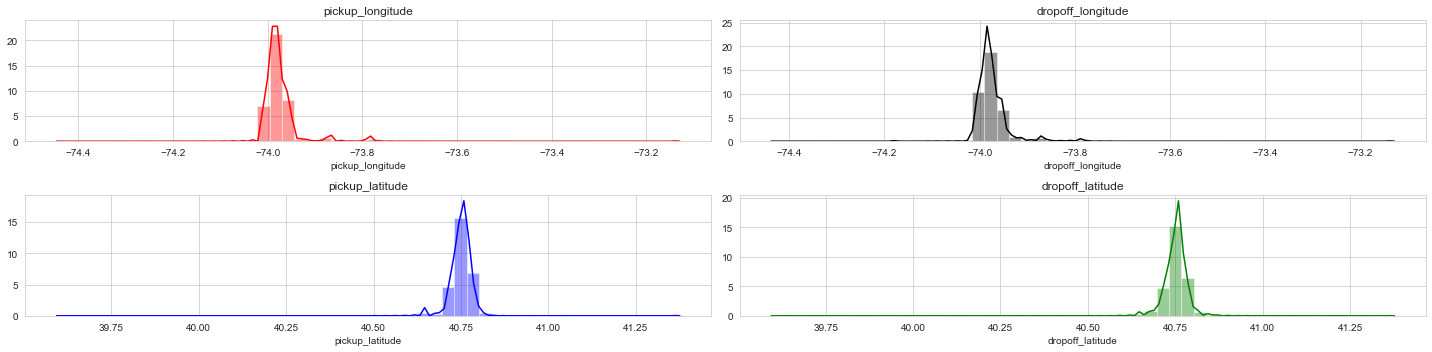

In [78]:
#lets plot some visualization with between latitude/longitude and fare_amount after missinf value imputation
#sns.set_style("whitegrid")
#plt.figure(figsize=(20,5))
#plt.subplot(221)
#sns.distplot(train["pickup_longitude"],color="red").set_title("pickup_longitude")
#plt.subplot(222)
#sns.distplot(train["dropoff_longitude"],color="black").set_title("dropoff_longitude")
#plt.subplot(223)
#sns.distplot(train["pickup_latitude"],color="blue").set_title("pickup_latitude")
#plt.subplot(224)
#sns.distplot(train["dropoff_latitude"],color="green").set_title("dropoff_latitude")
#plt.tight_layout()

# Feature Engineering

#  1)Trip Distance

In [29]:
#Using heversine method
df=[train,test]
for i in df:
    radius= 6378.1 
    dif_lat = np.radians(i["dropoff_latitude"] - i["pickup_latitude"])
    dif_long = np.radians(i["dropoff_longitude"] - i["pickup_longitude"])
    a = np.sin(dif_lat/2) * np.sin(dif_lat/2) + (np.cos(np.radians(i["pickup_latitude"]))
                                                         *np.cos(np.radians(i["dropoff_latitude"])) 
                                                         * np.sin(dif_long/2) * np.sin(dif_long/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    i["trip_distance"] = radius * c  # output distance in Kilometers    

In [30]:
train.shape  , test.shape

((15568, 8), (9914, 7))

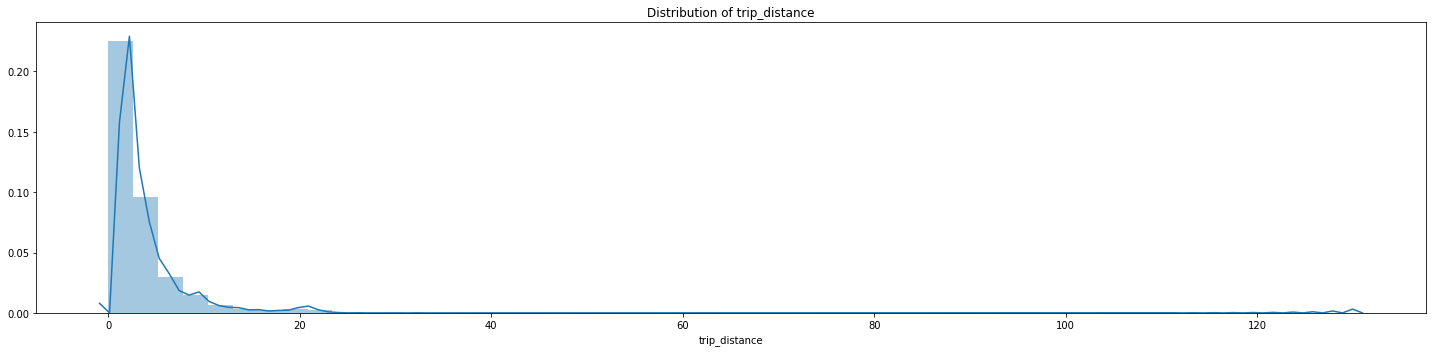

In [31]:
#See the Distribution of Trip_distance
plt.figure(figsize=(20,5))
sns.distplot(train["trip_distance"],bins=50)
plt.title("Distribution of trip_distance")
plt.xlabel("trip_distance")
plt.tight_layout()

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


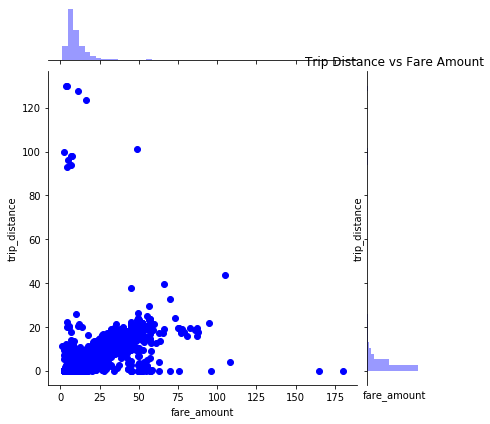

In [32]:
#Lets plot a curve to find the relation between trip_distance anf fare_amount
sns.jointplot(x="fare_amount",y="trip_distance",data=train,kind="scatter",color="blue")
plt.xlabel("fare_amount")
plt.ylabel("trip_distance")
plt.title("Trip Distance vs Fare Amount")
plt.tight_layout()

# 2)pickup_year,month,week day ,time 

In [33]:
#Creating some features based on pickup_datetime variable
df=[train,test]
for i in df:
    i["year"]=i["pickup_datetime"].apply(lambda x:x.year)
    i["month"]=i["pickup_datetime"].apply(lambda x:x.month)
    i["dayofweek"]=i["pickup_datetime"].apply(lambda x:x.dayofweek)
    i["hour"]=i["pickup_datetime"].apply(lambda x:x.hour)

In [35]:
train.head() , test.head()

(   fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  \
 0          4.5 2009-06-15 17:26:21        -73.844311        40.721319   
 1         16.9 2010-01-05 16:52:16        -74.016048        40.711303   
 2          5.7 2011-08-18 00:35:00        -73.982738        40.761270   
 3          7.7 2012-04-21 04:30:42        -73.987130        40.733143   
 4          5.3 2010-03-09 07:51:00        -73.968095        40.768008   
 
    dropoff_longitude  dropoff_latitude passenger_count  trip_distance  year  \
 0         -73.841610         40.712278               1       1.031913  2009   
 1         -73.979268         40.782004               1       8.459551  2010   
 2         -73.991242         40.750562               2       1.391074  2011   
 3         -73.991567         40.758092               1       2.802390  2012   
 4         -73.956655         40.783762               1       2.001385  2010   
 
    month  dayofweek  hour  
 0      6          0    17  
 1      1     

In [38]:
#before droping pickup_datetime columns lets make a data fare that help us to merge predicted value with test data
test_pickup_datetime=pd.DataFrame(test["pickup_datetime"])

In [40]:
test_pickup_datetime.head()

,pickup_datetime
0,2015-01-27 13:08:24
1,2015-01-27 13:08:24
2,2011-10-08 11:53:44
3,2012-12-01 21:12:12
4,2012-12-01 21:12:12


In [41]:
#Droping pickup_datetime variable
train=train.drop("pickup_datetime",axis=1)
test=test.drop("pickup_datetime",axis=1)

#First lets see how fare_amount varies with year,month,day,hour by ploting some visualizations

a) fare_amount with year

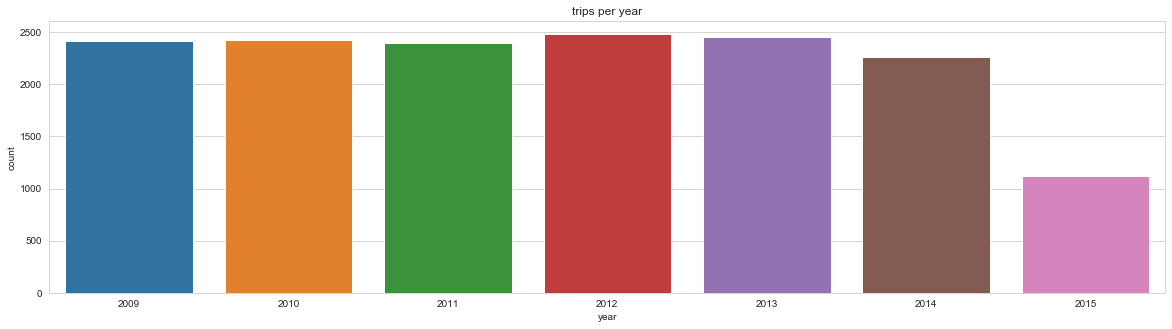

In [54]:
#Lets check how numbers of trips vary with year
plt.figure(figsize=[20,5])
ax=sns.countplot(train["year"]).set_title("trips per year")

In [55]:
avgfare_year=train.groupby(["year"])["fare_amount"].mean().reset_index()
avgfare_year=avgfare_year.rename(columns={"fare_amount":"Avg_fare"})

In [56]:
avgfare_year

,year,Avg_fare
0,2009,10.237289
1,2010,9.983124
2,2011,10.348716
3,2012,11.418901
4,2013,12.267346
5,2014,13.008834
6,2015,12.791984


Text(0.5, 1.0, 'Avg Fare Amount over Years')

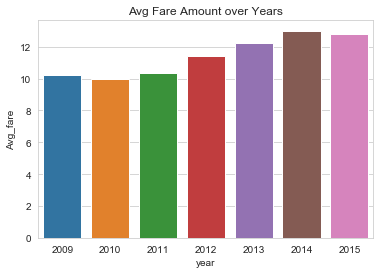

In [57]:
#Lets check how fare_amount varies with year
sns.barplot(x='year',y='Avg_fare',data=avgfare_year).set_title("Avg Fare Amount over Years")               

From above we can clearly say that fare_amount is increasing with pickup_year

b) fare_amount and month

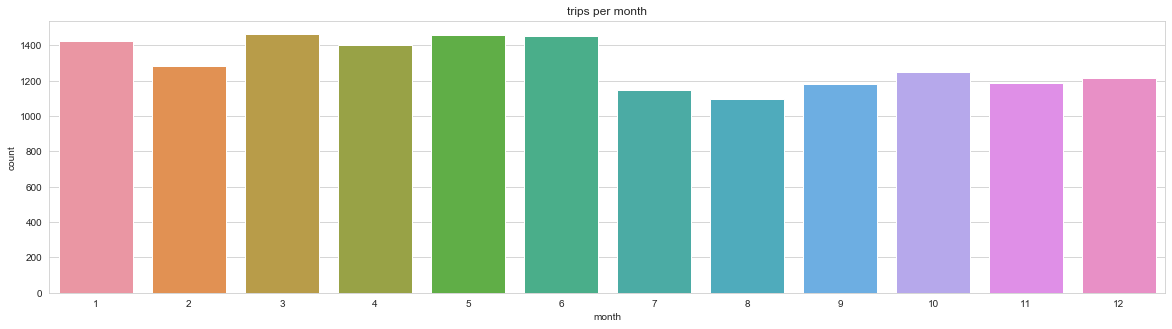

In [58]:
#Lets check how numbers of trips vary with months
plt.figure(figsize=[20,5])
ax=sns.countplot(train["month"]).set_title("trips per month")

In [59]:
avgfare_month=train.groupby(["month"])["fare_amount"].mean().reset_index()
avgfare_month=avgfare_month.rename(columns={"fare_amount":"Avg_fare"})

Text(0.5, 1.0, 'Avg Fare Amount over months')

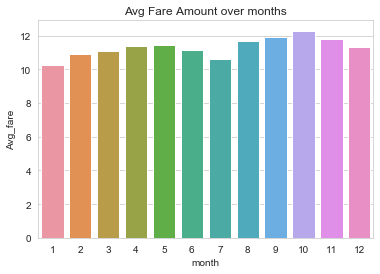

In [60]:
#Lets check how fare_amount varies with 
sns.barplot(x='month',y='Avg_fare',data=avgfare_month).set_title("Avg Fare Amount over months")

avg fare amount is varying with months, avg fare from month 2 to 5 and 8 to 12 is high as compare to other months

c) fare_amount and pickup_dayofweek

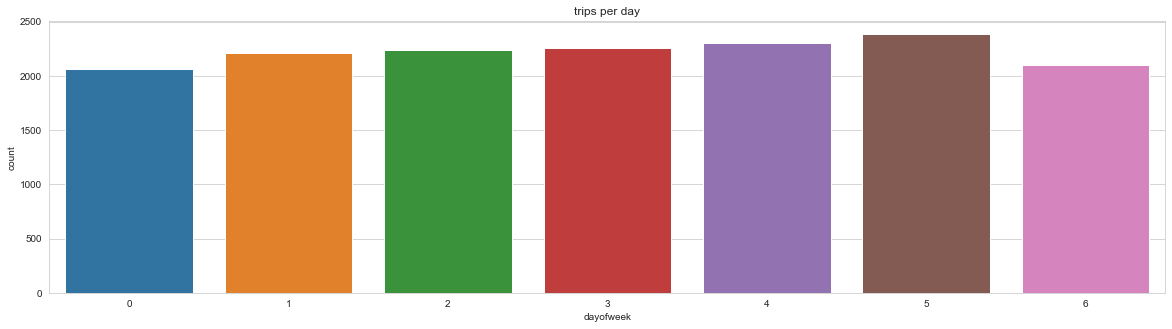

In [61]:
#Lets check how numbers of trips vary with day
plt.figure(figsize=[20,5])
ax=sns.countplot(train["dayofweek"]).set_title("trips per day")

In [62]:
avgfare_day=train.groupby(["dayofweek"])["fare_amount"].mean().reset_index()
avgfare_day=avgfare_day.rename(columns={"fare_amount":"Avg_fare"})

Text(0.5, 1.0, 'Avg Fare Amount over day')

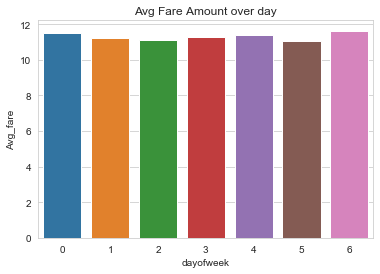

In [63]:
#Lets check how fare_amount varies with year
sns.barplot(x='dayofweek',y='Avg_fare',data=avgfare_day).set_title("Avg Fare Amount over day")

fare is almost same on every day of week except for weekends, it is slightly higher on saturday and sunday

d) fare_amount with hour

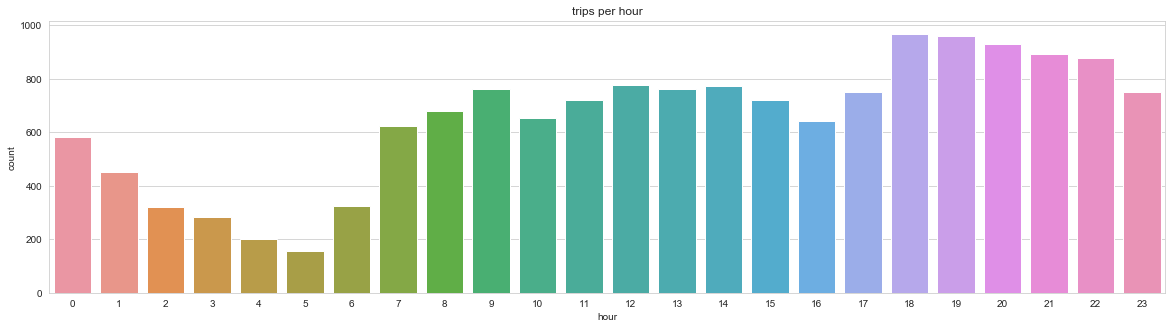

In [64]:
#Lets check how numbers of trips vary with day
plt.figure(figsize=[20,5])
ax=sns.countplot(train["hour"]).set_title("trips per hour")

In [65]:
avgfare_hour=train.groupby(["hour"])["fare_amount"].mean().reset_index()
avgfare_hour=avgfare_hour.rename(columns={"fare_amount":"Avg_fare"})

Text(0.5, 1.0, 'Avg Fare Amount over hour')

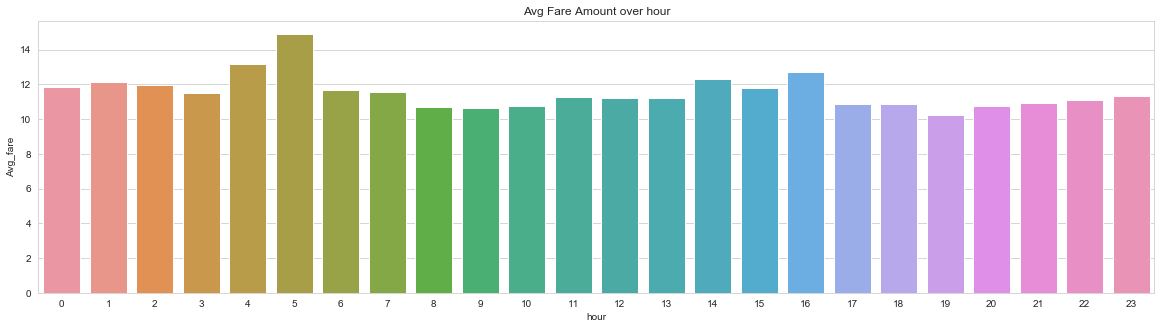

In [66]:
#Lets check how fare_amount varies with hour
plt.figure(figsize=(20,5))
sns.barplot(x='hour',y='Avg_fare',data=avgfare_hour).set_title("Avg Fare Amount over hour")

fare_amount is highest at 5 AM. It is higher from 1 AM to 5 AM and 2 PM to 4 PM

In [37]:
train.shape, test.shape

((15568, 11), (9914, 10))

In [38]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,year,month,dayofweek,hour
count,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000
mean,11.310989,-73.974803,40.750920,-73.973839,40.751410,3.412856,2011.733428,6.268885,3.033530,13.501156
std,9.615190,0.041564,0.038032,0.039393,0.039694,4.593500,1.869270,3.447543,1.970106,6.507419
min,1.140000,-74.438233,39.603178,-74.429332,39.604972,0.000000,2009.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992375,40.736589,-73.991372,40.736333,1.258931,2010.000000,3.000000,1.000000,9.000000
50%,8.500000,-73.982051,40.753357,-73.980563,40.754242,2.174004,2012.000000,6.000000,3.000000,14.000000
75%,12.500000,-73.968082,40.767808,-73.965397,40.768331,3.903528,2013.000000,9.000000,5.000000,19.000000
max,180.000000,-73.137393,41.366138,-73.137393,41.366138,130.095302,2015.000000,12.000000,6.000000,23.000000


In [69]:
train.info() , test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15568 entries, 0 to 16065
Data columns (total 11 columns):
fare_amount          15568 non-null float64
pickup_longitude     15568 non-null float64
pickup_latitude      15568 non-null float64
dropoff_longitude    15568 non-null float64
dropoff_latitude     15568 non-null float64
passenger_count      15568 non-null object
trip_distance        15568 non-null float64
year                 15568 non-null int64
month                15568 non-null int64
dayofweek            15568 non-null int64
hour                 15568 non-null int64
dtypes: float64(6), int64(4), object(1)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 10 columns):
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null object
trip_distance        9914 non-nul

(None, None)

In [42]:
for i in ["year","month","hour","dayofweek"]:
    train[i]=train[i].astype(object)
    test[i]=test[i].astype(object)

# Feature selection

# Correlation curve for numeric variable

#Our target here is to remove the independent variable which have dependencies on each other, so if the correlation value is high between two independent variable we have to drop one of them

In [40]:
numeric=["fare_amount","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude","trip_distance"]

In [41]:
df=train.loc[:,numeric]

In [42]:
df.shape

(15568, 6)

(0, 6)

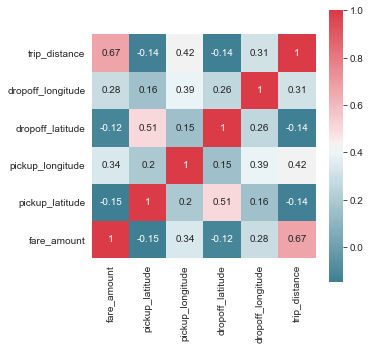

In [74]:
plt.figure(figsize=(5,5))
corr=df.corr()
ax=sns.heatmap(corr,cmap=sns.diverging_palette(220,10,as_cmap=True),square=True,annot=True)
ax.set_ylim(0,6)

As we can see that no variable is highly coorelated with other.

# Chi-square thest for categorical variables

Hypothesis testing;  Null Hypothesis: two variables are independent,
                       Alternate Hypothesis: two variables are not independent.
We do chi-square test to find out whether to reject the null hypothesis or to accept it, If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent and if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 
Our target here is to remove the independent variable which have dependencies on each other,So we will remove that variable whose p-value with other variable is low than 0.05

In [75]:
objects=["passenger_count","year","month","hour"]

In [76]:
for i in objects:
    for j in objects:
        if(i != j):
            print(i,"and",j)
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            print(p>0.05,p)

passenger_count and year
False 1.3398554689625531e-30
passenger_count and month
True 0.09174499105258749
passenger_count and hour
False 8.9524811703997e-12
year and passenger_count
False 1.3398554689625531e-30
year and month
False 1.4256260751980676e-183
year and hour
True 0.14942721560772002
month and passenger_count
True 0.09174499105258749
month and year
False 1.4256260751979857e-183
month and hour
True 0.7390110410762918
hour and passenger_count
False 8.9524811703997e-12
hour and year
True 0.14942721560772002
hour and month
True 0.7390110410762918


SO, We write the variables with higher p-value from above: 
(passenger_count and month,True,0.14122278751501335),
(year and hour,True,0.15886983764220838),
(hour and month,True,0.6855686895917862),
(dayofweek and year,True,0.1370572991993649) and (dayofweek and month,True,0.2942806449248877)

from plots we done in feature engineering step between fare_amount / year, month, dayofweek and hour, we can see dayoff_week does not have much effect on fare_amount. so before dropping any variable lets do ANOVA test to see relationship of these categorical variables and Target variable 

#Befor that lets see the variation in fare_amount with passenger_count

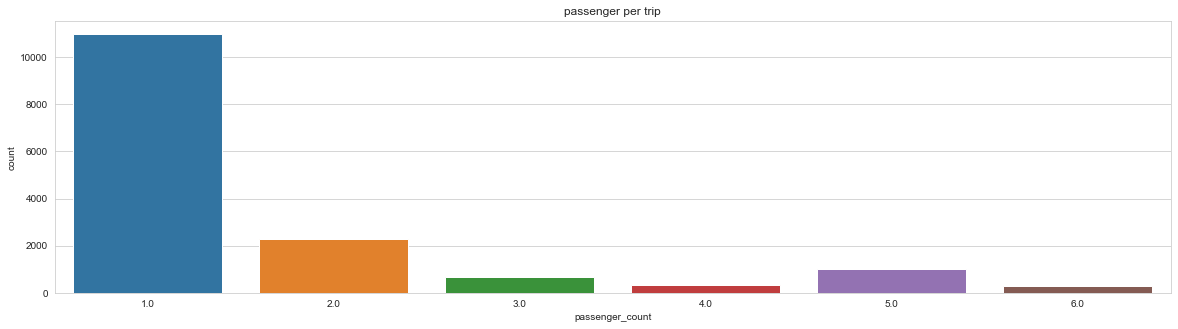

In [148]:
#Lets check how numbers of trips vary with each value of passenger_count
plt.figure(figsize=[20,5])
ax=sns.countplot(train["passenger_count"]).set_title("passenger per trip")

most of the ride are with passenger_count 1

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


<Figure size 1440x360 with 0 Axes>

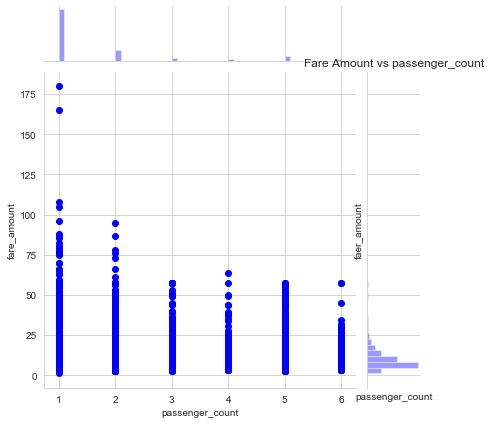

In [144]:
plt.figure(figsize=(20,5))
sns.jointplot(x="passenger_count",y="fare_amount",data=train,kind="scatter",color="blue")
plt.xlabel("passenger_count")
plt.ylabel("faer_amount")
plt.title("Fare Amount vs passenger_count")
plt.tight_layout()

fare_amount is higher in case of passenger_count 1 and 2.

# ANOVA - Analysis of variance

ANOVA only lets us know the means for different groups are same or not.
Hypothesis testing; Null Hypothesis: mean of all categories in a variable are same, Alternate Hypothesis: mean of at least one category in a variable is different.
If p-value is less than 0.05 then we reject the null hypothesis.
And if p-value is greater than 0.05 then we accept the null hypothesis.

In [38]:
model = ols("fare_amount ~ C(passenger_count)+C(year)+C(dayofweek)+C(month)+C(hour)",data=train).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count),5.0,2.099163e+03,419.832699,4.648301,3.055335e-04
C(year),6.0,2.095049e+04,3491.748352,38.659920,6.697679e-47
C(dayofweek),6.0,6.181555e+02,103.025914,1.140682,3.355667e-01
C(month),11.0,5.892329e+03,535.666276,5.930787,1.022714e-09
C(hour),23.0,8.239487e+03,358.238581,3.966344,4.789158e-10
Residual,15516.0,1.401399e+06,90.319597,NaN,NaN


As we can see p value for pickup_dayofweek is greater than 0.05 hence we accept null hypothesis for the variable. we are dropping the variable by saying fare_amount have same mean for all values od pickup_dayofweek

In [43]:
train=train.drop("dayofweek",axis=1)

In [44]:
test=test.drop("dayofweek",axis=1)

In [41]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance
count,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000,15568.000000
mean,11.310989,-73.974803,40.750920,-73.973839,40.751410,3.412856
std,9.615190,0.041564,0.038032,0.039393,0.039694,4.593500
min,1.140000,-74.438233,39.603178,-74.429332,39.604972,0.000000
25%,6.000000,-73.992375,40.736589,-73.991372,40.736333,1.258931
50%,8.500000,-73.982051,40.753357,-73.980563,40.754242,2.174004
75%,12.500000,-73.968082,40.767808,-73.965397,40.768331,3.903528
max,180.000000,-73.137393,41.366138,-73.137393,41.366138,130.095302


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15568 entries, 0 to 16065
Data columns (total 10 columns):
fare_amount          15568 non-null float64
pickup_longitude     15568 non-null float64
pickup_latitude      15568 non-null float64
dropoff_longitude    15568 non-null float64
dropoff_latitude     15568 non-null float64
passenger_count      15568 non-null object
trip_distance        15568 non-null float64
year                 15568 non-null object
month                15568 non-null object
hour                 15568 non-null object
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


In [43]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.031913,2009,6,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.459551,2010,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.391074,2011,8,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.802390,2012,4,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2.001385,2010,3,7


# Features scaling

We have to do feature scaling of independent continous variable in out data set for both train and test data.

In [82]:
train.head() 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.031913,2009,6,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.459551,2010,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.391074,2011,8,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.802390,2012,4,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2.001385,2010,3,7


In [83]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,dayofweek,hour
0,-73.973320,40.763805,-73.981430,40.743835,1,2.325849,2015,1,1,13
1,-73.986862,40.719383,-73.998886,40.739201,1,2.428056,2015,1,1,13
2,-73.982524,40.751260,-73.979654,40.746139,1,0.619317,2011,10,5,11
3,-73.981160,40.767807,-73.990448,40.751635,1,1.963218,2012,12,5,21
4,-73.966046,40.789775,-73.988565,40.744427,1,5.393305,2012,12,5,21


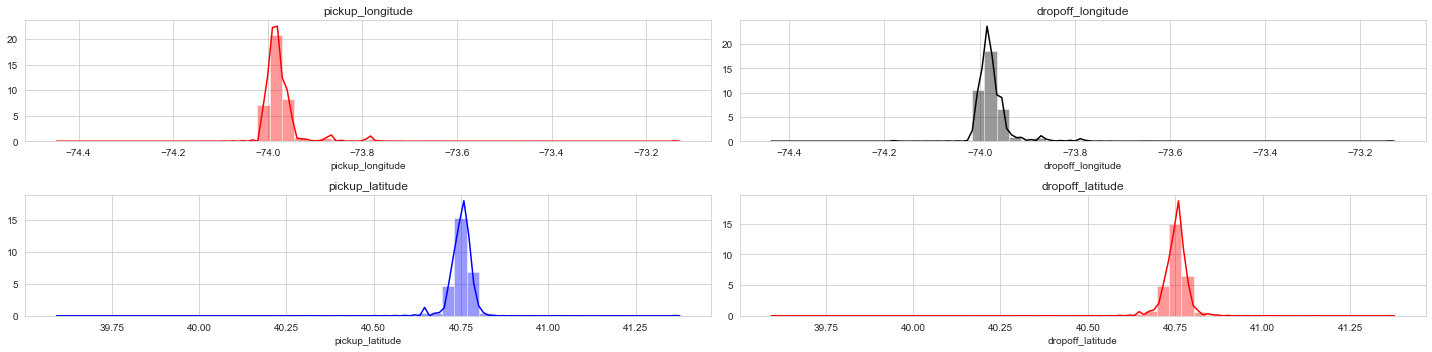

In [84]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.subplot(221)
sns.distplot(train["pickup_longitude"],color="red").set_title("pickup_longitude")
plt.subplot(222)
sns.distplot(train["dropoff_longitude"],color="black").set_title("dropoff_longitude")
plt.subplot(223)
sns.distplot(train["pickup_latitude"],color="blue").set_title("pickup_latitude")
plt.subplot(224)
sns.distplot(train["dropoff_latitude"],color="red").set_title("dropoff_latitude")
plt.tight_layout()

Our curve is not normally/ uniformally distributed.

From trip distance distribution plot in feature engineering we can see that it is not normally distribute.
#hence for feature scalling we should go for Normalization method

In [46]:
for i in ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","trip_distance"]:
    train[i] = (train[i] - min(train[i]))/(max(train[i]) - min(train[i]))
    test[i] = (test[i] - min(test[i]))/(max(test[i]) - min(test[i]))

In [45]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour
0,4.5,0.456568,0.634241,0.454915,0.628735,1,0.007932,2009,6,17
1,16.9,0.324548,0.628559,0.348363,0.668326,1,0.065026,2010,1,16
2,5.7,0.350155,0.656902,0.339095,0.650473,2,0.010693,2011,8,0
3,7.7,0.346778,0.640948,0.338843,0.654748,1,0.021541,2012,4,4
4,5.3,0.361411,0.660724,0.365866,0.669324,1,0.015384,2010,3,7


In [87]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,dayofweek,hour
0,0.220338,0.167776,0.221502,0.155060,1,0.023234,2015,1,1,13
1,0.209638,0.128686,0.207781,0.150950,1,0.024254,2015,1,1,13
2,0.213066,0.156736,0.222898,0.157102,1,0.006187,2011,10,5,11
3,0.214143,0.171297,0.214414,0.161976,1,0.019611,2012,12,5,21
4,0.226085,0.190628,0.215894,0.155584,1,0.053875,2012,12,5,21


# Dividing train data into train subset and test subset data

In [47]:
df=train.copy()

In [48]:
df.shape

(15568, 10)

In [49]:
X=df.drop(["fare_amount"],axis=1)
Y=df["fare_amount"]

In [86]:
#Dividing data in train and test subsets
x_train,x_test,y_train,y_test= train_test_split(X,Y, test_size=0.2)
print(df.shape,x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(15568, 10) (12454, 9) (3114, 9) (12454,) (3114,)


In [87]:
x_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour
8283,0.350597,0.660368,0.346022,0.665610,1,0.008422,2015,3,14
15645,0.394203,0.655548,0.441884,0.652388,3,0.043628,2012,9,23
4911,0.373961,0.661429,0.374258,0.668235,3,0.011447,2014,9,15
15986,0.351573,0.655614,0.346259,0.644491,4,0.016250,2011,8,21
13536,0.356334,0.646045,0.349914,0.651154,2,0.008408,2014,12,18


# Model Building

# 1) Linear regression

#Multicollinearity Test
-  VIF is always greater or equal to 1.
-  if VIF is 1 --- Not correlated to any of the variables.
-  if VIF is between 1-5 --- Moderately correlated.
-  if VIF is above 5 --- Highly correlated.
-  If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [51]:
#checking for multicolliearity 
outcome, predictors = dmatrices('fare_amount ~ pickup_latitude+pickup_longitude+dropoff_latitude+dropoff_longitude+trip_distance+passenger_count+year+hour+month',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,1256.032402,Intercept
1,1.040492,passenger_count[T.2.0]
2,1.020175,passenger_count[T.3.0]
3,1.012956,passenger_count[T.4.0]
4,1.027244,passenger_count[T.5.0]
5,1.019447,passenger_count[T.6.0]
6,1.695701,year[T.2010]
7,1.691477,year[T.2011]
8,1.711626,year[T.2012]
9,1.710126,year[T.2013]


No varaible with higher VIF

In [88]:
df_train=pd.get_dummies(x_train,columns=["passenger_count","year","month","hour"])

In [89]:
df_test=pd.get_dummies(x_test,columns=["passenger_count","year","month","hour"])

In [90]:
df_train.shape,df_test.shape

((12454, 54), (3114, 54))

In [91]:
integer=["passenger_count_1.0","passenger_count_2.0","passenger_count_3.0","passenger_count_4.0","passenger_count_5.0","passenger_count_6.0",
        "year_2009","year_2010","year_2011","year_2012","year_2013","year_2014","year_2015","month_1","month_2","month_3","month_4",
        "month_5","month_6","month_7","month_8","month_9","month_10","month_11","month_12","hour_0","hour_1","hour_2","hour_3","hour_4",
        "hour_5","hour_6","hour_7","hour_8","hour_9","hour_10","hour_11","hour_12","hour_13","hour_14","hour_15","hour_16","hour_17",
        "hour_18","hour_19","hour_20","hour_21","hour_22","hour_23"]
for i in integer:
    df_train[i]= df_train[i].astype(int)
    df_test[i]=df_test[i].astype(int)

In [58]:
df_train.info(),df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12454 entries, 6694 to 4897
Data columns (total 54 columns):
pickup_longitude       12454 non-null float64
pickup_latitude        12454 non-null float64
dropoff_longitude      12454 non-null float64
dropoff_latitude       12454 non-null float64
trip_distance          12454 non-null float64
passenger_count_1.0    12454 non-null int32
passenger_count_2.0    12454 non-null int32
passenger_count_3.0    12454 non-null int32
passenger_count_4.0    12454 non-null int32
passenger_count_5.0    12454 non-null int32
passenger_count_6.0    12454 non-null int32
year_2009              12454 non-null int32
year_2010              12454 non-null int32
year_2011              12454 non-null int32
year_2012              12454 non-null int32
year_2013              12454 non-null int32
year_2014              12454 non-null int32
year_2015              12454 non-null int32
month_1                12454 non-null int32
month_2                12454 non-null int32

(None, None)

In [92]:
df_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
8283,0.350597,0.660368,0.346022,0.665610,0.008422,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15645,0.394203,0.655548,0.441884,0.652388,0.043628,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4911,0.373961,0.661429,0.374258,0.668235,0.011447,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
15986,0.351573,0.655614,0.346259,0.644491,0.016250,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
13536,0.356334,0.646045,0.349914,0.651154,0.008408,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [93]:
model=sm.OLS(y_train,df_train).fit()

In [94]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     263.1
Date:                Wed, 08 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:24:34   Log-Likelihood:                -41302.
No. Observations:               12454   AIC:                         8.271e+04
Df Residuals:                   12403   BIC:                         8.309e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
pickup_longitude       25.6144      2.262     11.325      0.000      21.181      30.048
pickup_latitude       -52.4548      3.459    -15.166      0.000     -59.234     -45.675
dropoff_longitude      14.4032      2.322      6.203      0.000       9.851      18.955
dropoff_latitude       11.1828      3.294      3.395      0.001       4.725      17.640
trip_distance         178.1287      2.096     84.971      0.000     174.020     182.238
passenger_count_1.0     7.2969      0.832      8.774      0.000       5.667       8.927
passenger_count_2.0     8.0014      0.839      9.533      0.000       6.356       9.647
passenger_count_3.0     7.8057      0.868      8.989      0.000       6.104       9.508
passenger_count_4.0     7.4723      0.907      8.235      0.000       5.694       9.251
passenger_count_5.0     7.5066      0.855      8.775      0.000       5.830       9.183
passenger_count_6.0     6.9226      0.914      7.572      0.000       5.131       8.715
year_2009               5.1368      0.726      7.074      0.000       3.713       6.560
year_2010               5.1036      0.723      7.062      0.000       3.687       6.520
year_2011               5.1389      0.718      7.153      0.000       3.731       6.547
year_2012               6.2874      0.721      8.717      0.000       4.874       7.701
year_2013               7.3161      0.721     10.142      0.000       5.902       8.730
year_2014               7.7889      0.723     10.779      0.000       6.372       9.205
year_2015               8.2338      0.741     11.116      0.000       6.782       9.686
month_1                 2.9521      0.454      6.496      0.000       2.061       3.843
month_2                 3.2249      0.458      7.041      0.000       2.327       4.123
month_3                 3.5171      0.452      7.776      0.000       2.631       4.404
month_4                 3.4411      0.453      7.605      0.000       2.554       4.328
month_5                 3.7820      0.457      8.278      0.000       2.886       4.678
month_6                 3.6388      0.455      7.995      0.000       2.747       4.531
month_7                 3.4196      0.463      7.389      0.000       2.512       4.327
month_8                 3.7098      0.467      7.940      0.000       2.794       4.626
month_9                 4.3568      0.465      9.371      0.000       3.446       5.268
month_10                4.5866      0.458     10.014      0.000       3.689       5.484
month_11                4.1931      0.465      9.013      0.000       3.281       5.105
month_12                4.1835      0.463      9.030      0.000       3.275       5.092
hour_0                  1.5588      0.361      4.317      0.000       0.851       2.267
hour_1                  1.5256      0.394      3.871      0.000       0.753       2.298
hou

Lets see the effect of different variable on our model by plotting cureve between varaible and regression coefficients

In [95]:
coeff=pd.DataFrame(model.params)
coeff=coeff.reset_index()
coeff=coeff.rename(columns={"index":"variable",0:"coeff"})

In [96]:
coeff

,variable,coeff
0,pickup_longitude,25.614419
1,pickup_latitude,-52.454776
2,dropoff_longitude,14.403235
3,dropoff_latitude,11.182817
4,trip_distance,178.128687
5,passenger_count_1.0,7.296859
6,passenger_count_2.0,8.001409
7,passenger_count_3.0,7.805678
8,passenger_count_4.0,7.472323
9,passenger_count_5.0,7.506607


Text(0.5, 1.0, 'Regression Coeff')

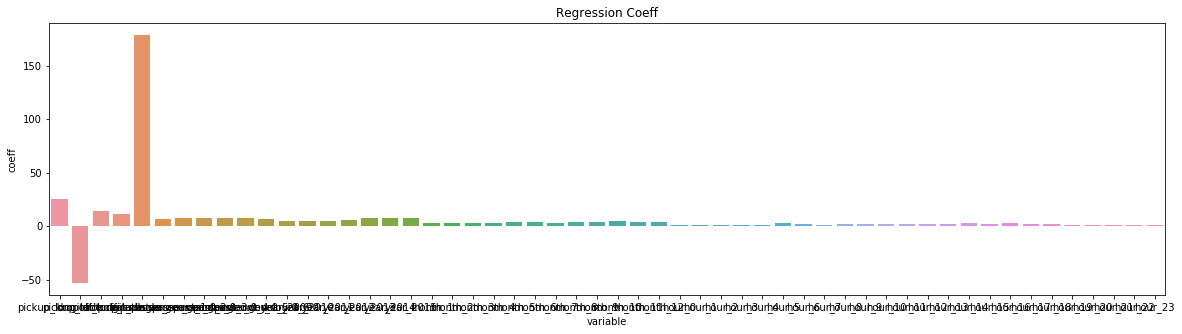

In [97]:
#Lets check how fare_amount varies with hour
plt.figure(figsize=(20,5))
sns.barplot(x='variable',y='coeff',data=coeff).set_title("Regression Coeff")

In [98]:
y_pred=model.predict(df_test)

In [1]:
print('MAPE:{}'.format(np.mean(np.abs((y_test - y_pred) / y_test))*100))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

NameError: name 'np' is not defined

# 2)Decision Tree

In [80]:
fit=DecisionTreeRegressor().fit(x_train,y_train)

In [81]:
fit

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [82]:
y_pred_DT=fit.predict(x_test)

In [83]:
print('r square  ', metrics.r2_score(y_test, y_pred_DT))
print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y_test, y_pred_DT))*(len(y_test)-1)/(len(y_test)-df_train.shape[1]-1)))
print('MAPE:{}'.format(np.mean(np.abs((y_test - y_pred_DT) / y_test))*100))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_DT))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_DT)))

r square   0.6931678990536515
Adjusted r square:0.6877514448362265
MAPE:27.92507097296705
MSE: 24.118490269749522
RMSE: 4.911057958296717


# 3)Random Forest

In [71]:
rf = RandomForestRegressor(n_estimators = 300)

In [77]:
model_RF = rf.fit(x_train,y_train)

In [67]:
model_RF

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [78]:
y_pred_RF=model_RF.predict(x_test)

In [79]:
print('r square  ', metrics.r2_score(y_test, y_pred_RF))
print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y_test, y_pred_RF))*(len(y_test)-1)/(len(y_test)-x_train.shape[1]-1)))
print('MAPE:{}'.format(np.mean(np.abs((y_test - y_pred_RF) / y_test))*100))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_RF))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))

r square   0.8076270696962413
Adjusted r square:0.8070692873596647
MAPE:22.21276239634232
MSE: 15.121444703420043
RMSE: 3.888630183421926


# 4) KNN Imputation

In [102]:
model_KNN=KNeighborsRegressor(n_neighbors=3).fit(x_train,y_train)

In [103]:
model_KNN

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [104]:
y_pred_KNN=model_KNN.predict(x_test)

In [105]:
print('r square  ', metrics.r2_score(y_test, y_pred_KNN))
print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y_test, y_pred_KNN))*(len(y_test)-1)/(len(y_test)-x_train.shape[1]-1)))
print('MAPE:{}'.format(np.mean(np.abs((y_test - y_pred_KNN) / y_test))*100))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_KNN))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNN)))

r square   0.05133911478471764
Adjusted r square:0.048588487218049536
MAPE:47.908605117283656
MSE: 90.65123916720188
RMSE: 9.521094431167137


# Error Matrix

we select RMSE for error matrix as our fare_amount is time based data and some of its values are higher as compare to other value. so as we can see RMSE from Random forest algorithm is lowest, hence we do our prediction on bases of model build using Random forest

# Prediction

In [106]:
test["fare_amount"]=model_RF.predict(test)

In [107]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour,fare_amount
0,0.220338,0.167776,0.221502,0.155060,1,0.023234,2015,1,13,31.041633
1,0.209638,0.128686,0.207781,0.150950,1,0.024254,2015,1,13,30.360533
2,0.213066,0.156736,0.222898,0.157102,1,0.006187,2011,10,11,17.460667
3,0.214143,0.171297,0.214414,0.161976,1,0.019611,2012,12,21,36.504333
4,0.226085,0.190628,0.215894,0.155584,1,0.053875,2012,12,21,22.292400


In [108]:
test_results= pd.merge(test,test_pickup_datetime,right_index=True,left_index=True)

In [110]:
test_results

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,hour,fare_amount,pickup_datetime
0,0.220338,0.167776,0.221502,0.155060,1,0.023234,2015,1,13,31.041633,2015-01-27 13:08:24
1,0.209638,0.128686,0.207781,0.150950,1,0.024254,2015,1,13,30.360533,2015-01-27 13:08:24
2,0.213066,0.156736,0.222898,0.157102,1,0.006187,2011,10,11,17.460667,2011-10-08 11:53:44
3,0.214143,0.171297,0.214414,0.161976,1,0.019611,2012,12,21,36.504333,2012-12-01 21:12:12
4,0.226085,0.190628,0.215894,0.155584,1,0.053875,2012,12,21,22.292400,2012-12-01 21:12:12
...,...,...,...,...,...,...,...,...,...,...,...
9909,0.224443,0.196983,0.241770,0.187473,6,0.021250,2015,5,12,32.433067,2015-05-10 12:37:51
9910,0.242310,0.202794,0.238178,0.183911,6,0.032711,2015,1,17,35.773367,2015-01-12 17:05:51
9911,0.205895,0.135044,0.372167,0.069200,6,0.191847,2015,4,20,56.423200,2015-04-19 20:44:15
9912,0.210657,0.142808,0.254711,0.206399,6,0.083438,2015,1,1,31.269033,2015-01-31 01:05:19


In [112]:
test_pred=test_results.loc[:,["pickup_datetime","fare_amount"]]

In [152]:
test_pred.head()

,pickup_datetime,fare_amount
0,2015-01-27 13:08:24,31.041633
1,2015-01-27 13:08:24,30.360533
2,2011-10-08 11:53:44,17.460667
3,2012-12-01 21:12:12,36.504333
4,2012-12-01 21:12:12,22.292400


In [124]:
test_copy["pickup_datetime"]=pd.to_datetime(test_copy["pickup_datetime"], format= "%Y-%m-%d %H:%M:%S UTC")

In [153]:
test_copy.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [161]:
test_results= pd.merge(test_copy,test_pred,right_index=True,left_index=True)

In [163]:
test_results=test_results.drop(test_results.columns[0],axis=1)

In [164]:
test_results.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_y,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,2015-01-27 13:08:24,31.041633
1,-73.986862,40.719383,-73.998886,40.739201,1,2015-01-27 13:08:24,30.360533
2,-73.982524,40.751260,-73.979654,40.746139,1,2011-10-08 11:53:44,17.460667
3,-73.981160,40.767807,-73.990448,40.751635,1,2012-12-01 21:12:12,36.504333
4,-73.966046,40.789775,-73.988565,40.744427,1,2012-12-01 21:12:12,22.292400


In [165]:
#writing output as CSV File
test_results.to_csv("test_predicted_python.csv",index=False)